In [1]:
import scipy.io as scio 
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA 
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, spectral_clustering
from sklearn.feature_extraction import image
import spectral as sp
import numpy as np
import glob
import os
import skimage as ski 
from skimage.measure import block_reduce
import skfuzzy as skf
from configparser import ConfigParser
from scipy import ndimage 
import matplotlib.image as mpimg
import sompy
import pandas as pd

backend module://ipykernel.pylab.backend_inline version unknown


In [2]:
# Loading Up Images for defaults 

pavia = {'rgb': scio.loadmat('PaviaRGB.mat')['PaviaRGB'],
         'color_map' : scio.loadmat('PaviaColorMap.mat')['PaviaColorMap'],
         'ground_truth' : scio.loadmat('PaviaGrTruth.mat')['PaviaGrTruth'],
         'ground_truth_mask' : scio.loadmat('PaviaGrTruthMask.mat')['PaviaGrTruthMask'],
         'hyperimage' : scio.loadmat('PaviaHyperIm.mat')['PaviaHyperIm'],
         'wavelengths' : scio.loadmat('PaviaWavelengths.mat')['PaviaWavelengths'],
        }
sanbar = {'rgb': scio.loadmat('SanBarRGB.mat')['SanBarRGB'],
          'wavelengths': scio.loadmat('SanBarWavelengths.mat')['WaveLengths'],
          'hyperimage': scio.loadmat('SanBarHyperIm.mat')['SanBarIm88x400'],
         }

## Loading up Config Parameters 

config = ConfigParser()
config.read('appConfig.ini')


def k_means_clustering(n_clusters=2,inp_image=pavia['rgb']):
    if inp_image is None:
        print("Empty Input. Exiting")
        return None 
    # Create K Means Model 
    k_means = KMeans(n_clusters=n_clusters)
    shape = inp_image.shape
    # Fit on Input Image 
    k_means.fit(inp_image.flatten().reshape(shape[0]*shape[1],shape[2]))
    # Get Cluster Labels
    inp_clustered = k_means.labels_.astype(float)
    
    return inp_clustered.reshape(shape[0]*shape[1],1).reshape(shape[0],shape[1])


def fuzzy_c_means(n_clusters=2, inp_image=pavia['rgb']):
    if inp_image is None:
        print("Empty Input. Exiting")
        return 
    
    shape = inp_image.shape
    # Create and Train on FCM Model 
    centers, u, u0, d, jm, n_iters, fpc = skf.cluster.cmeans(
        inp_image.flatten().reshape(shape[0]*shape[1],shape[2]).T,
        c=n_clusters,
        m=float(config['FCM']['FUZZ_DEGREE']),
        error=float(config['FCM']['ERROR']),
        maxiter=int(config['FCM']['MAX_ITER']),
        init=None,
        seed=int(config['FCM']['SEED'])
    )
    # Get Cluster Labels with Max Porbability 
    clust = np.argmax(u, axis=0).astype(float)
    
    return clust.reshape(shape[0]*shape[1],1).reshape(shape[0],shape[1])


def gaussian_mixture_model(n_clusters=2,inp_image=pavia['rgb']):
    shape = inp_image.shape
    inp_image = inp_image.flatten().reshape(shape[0]*shape[1],shape[2])
    # Create Gaussian Mixture Model with Config Parameters
    gmm = GaussianMixture(
        n_components=n_clusters, covariance_type=config['GMM']['COVARIANCE_TYPE'],
        max_iter=int(config['GMM']['MAX_ITER']), random_state=int(config['GMM']['RANDOM_STATE']))
    # Fit on Input Image
    gmm.fit(X=inp_image)
    # Get Cluster Labels 
    clust = gmm.predict(X=inp_image)
    
    return clust.reshape(shape[0]*shape[1],1).reshape(shape[0],shape[1])
   
def spectral_cluster(n_clusters=2, inp_image=pavia['rgb']):
    downsample = block_reduce(inp_image, (8,4,1), func=np.max)
    graph = image.img_to_graph(downsample)
    graph.data = np.exp(-graph.data / graph.data.std())
    return spectral_clustering(graph, n_clusters=n_clusters, eigen_solver=config['SPECTRAL']['EIGEN_SOLVER'])
    
def SOM(n_clusters=5, n_job=5, map_dim=20, inp_image=pavia['rgb']):

    # Calculate the map
    mapsize = [map_dim,map_dim]
    shape = inp_image.shape
    data = inp_image.flatten().reshape(shape[0]*shape[1],shape[2])
    som = sompy.SOMFactory.build(data, mapsize)  
    som.train(n_job=n_job, verbose=None)
    
    #calculating clusters
    cl = som.cluster(n_clusters=n_clusters)
    
    # calculating which pixel is associated which cluster
    project_data = som.project_data(data)
    clust = np.zeros((shape[0], shape[1]))
    for i, q in enumerate(project_data):
        temp = cl[q]
        clust[np.unravel_index(i, dims=((shape[0], shape[1])))] = temp

    return clust

def postprocess(inp_image):
    # Median filter as a post processing step to remove small clusters.
    window_size = int(config['MEDIAN_FILTER']['WINDOW_SIZE'])
    return ndimage.median_filter(inp_image, size=window_size)

In [3]:
def MyClust(image=pavia['rgb'],params={'Algorithm': 'KMeans',
                                       'ImType': 'RGB',
                                       'NumClusts': 3}):
    # Preprocessing Input Image
    #inp_image = preprocess(image)
    
    shape = image.shape
    CCIm = None
    out_labels = None 
    nr_objects = None 
    
    if params['ImType'].upper() == 'HYPER':
        # Dimensionality Reduction for Hyperimage 
        n_components = int(config['HYPER']['N_COMPONENTS'])
        hyper = image.flatten().reshape(shape[0]*shape[1],shape[2])
        pca = PCA(n_components=n_components, svd_solver='auto').fit(hyper)
        image = pca.transform(hyper).reshape(shape[0],shape[1],n_components)
    
    # Resetting Shape in case input was hyper image and underwent dimensionality reduction 
    shape = image.shape
    
    n_clusters = params['NumClusts']
    if params['NumClusts'] > 0.25 * shape[0] * shape[1]:
        print('NumClusts higher than 25% of Number of Pixels\nExiting...')
    elif params['NumClusts'] == 1:
        n_clusters = int(0.05 * shape[0] * shape[1])
    
    
    if params['Algorithm'].upper() == 'KMEANS':
        out_labels = k_means_clustering(n_clusters=n_clusters, inp_image=image)   
    
    elif params['Algorithm'].upper() == 'FCM':
        out_labels = fuzzy_c_means(n_clusters=n_clusters, inp_image=image)   
    
    elif params['Algorithm'].upper() == 'SOM':    
        out_labels = SOM(n_clusters=n_clusters,n_job =int(config['SOM']['N_JOB']),
                         map_dim=int(config['SOM']['MAP_DIM']),
                         inp_image=image)

    elif params['Algorithm'].upper() == 'SPECTRAL':
        out_labels = spectral_cluster(n_clusters=n_clusters, inp_image=image)
    elif params['Algorithm'].upper() == 'GMM':
        out_labels = gaussian_mixture_model(n_clusters=n_clusters, inp_image=image)
    else:
        print('Invalid Algorithm Entered')
        return None, None 
    
    if params['ImType'].upper() == 'RGB':
        out_labels = postprocess(out_labels)
        CCIm, nr_objects = ndimage.label(out_labels)
        
    return out_labels, CCIm, nr_objects
     

In [4]:
out_labels, CCIm, nr_objects = MyClust(image=pavia['rgb'], params={'Algorithm': 'FCM',
                                                      'ImType': 'rgb',
                                                      'NumClusts': 5})

In [5]:
out_labels

array([[3., 3., 3., ..., 0., 0., 0.],
       [3., 3., 3., ..., 0., 0., 0.],
       [3., 3., 3., ..., 0., 0., 0.],
       ...,
       [4., 4., 4., ..., 0., 0., 0.],
       [4., 4., 4., ..., 0., 0., 0.],
       [4., 4., 4., ..., 0., 0., 0.]])

findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/home/srajan/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


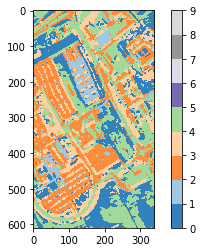

In [6]:
def label_show(im):
    cmap = cm.get_cmap('tab20c', 9)
    plt.imshow(im, cmap=cmap, vmin=0, vmax=9)
    plt.colorbar(ticks=np.linspace(0,9,10))
    plt.show()
label_show(out_labels)

## Evaluation

In [7]:
def PartialError(g, s):
    """Patial Error function."""
    
    clust_g = np.unique(g)
    clust_s = np.unique(s)
    err = 0.0

    for j in clust_g:
        # initializing inner summation is the formaula.
        inner = 0.0
        
        Aj = (g == j)
        Wj = 0.0
        Wj += np.sum(Aj,dtype=np.float_)/(g.size)
        
        # calculating denominator for Wji
        Wji_den = np.sum([(np.sum(np.logical_and(Aj, s == x))!=0) * np.sum(s == x) for x in clust_s],
                         dtype=np.float_)
        
        # calculating inner summation
        for i in clust_s:
            # Wji
            Bi = ( s == i )
            Wji = ((np.sum(np.logical_and(Aj,Bi),dtype=np.float_)!=0) * np.sum(Bi)) / Wji_den

            inner += (np.sum(np.logical_and(Aj,Bi),dtype=np.float_) / 
                      np.sum(np.logical_or(Aj,Bi),dtype=np.float_))*Wji

            
        # calculating outer summation
        err += (1-inner)*Wj

    return err

In [8]:
def MyMartinIndex7(gtImage, sImage):
    """Object-level Consistency Error Martin Index."""
    clust_gtImage = np.unique(gtImage)
    clust_sImage = np.unique(sImage)
    score = np.min([PartialError(gtImage, sImage), PartialError(sImage, gtImage)])
    return score 

In [9]:
gt = np.array([[1, 1, 1, 1],
               [1, 1, 1, 1],
               [1, 1, 1, 1],
               [1, 1, 1, 1]])

im1=np.array([ [1, 1, 1, 1],
               [1, 1, 1, 1],
               [1, 1, 1, 1],
               [1, 1, 1, 1]])

im2=np.array([ [1, 1, 2, 2],
               [1, 1, 2, 2],
               [1, 1, 2, 2],
               [1, 1, 2, 2]])

im3=np.array([ [1, 1, 2, 2],
               [1, 1, 2, 2],
               [1, 1, 3, 3],
               [1, 1, 3, 3]])
im4=np.zeros((4,4), dtype=np.int16)

# Test 1: Perfect match
assert MyMartinIndex7(gt,im1)==0

# Test 2: Terrible match
assert MyMartinIndex7(gt,im4)==0

# Test 3: Example 1
assert MyMartinIndex7(gt,im2)==0.5

# Test 4: Example 2
assert MyMartinIndex7(gt,im3)==0.625

print("All Tests ran sucessfully.")

All Tests ran sucessfully.


In [10]:
def MyClustEvalRGB(gtImage1, gtImage2, gtImage3, sImage):
    score1 = np.min([PartialError(gtImage1, sImage), PartialError(sImage, gtImage1)])
    score2 = np.min([PartialError(gtImage2, sImage), PartialError(sImage, gtImage2)])
    score3 = np.min([PartialError(gtImage3, sImage), PartialError(sImage, gtImage3)])
    scores = np.array([score1, score2, score3])
    return np.min(scores)

In [11]:
def MyClustEvalRGB7(algo="KMeans",imType="rgb", numClusts = 5):
    scores = []
    i =0
    for mat_file in glob.glob('ImsAndSegs/*.mat'):
        if i==3:
            break;
        i +=1
        img = scio.loadmat(mat_file)
        seg1 = img['Seg1']
        seg2 = img['Seg2']
        seg3 = img['Seg3']
        sImage, CCIm, nr_objects = MyClust(image=img['Im'], params={'Algorithm': algo,
                                                      'ImType': imType,
                                                      'NumClusts': numClusts})
        score = MyClustEvalRGB(seg1, seg2, seg3, sImage)
        scores.append(score)
        #print(score)
    # mean for all 198 images for a given clustering algo
    mean = np.mean(scores)
    #standard deviation for the clustering algo
    std = np.std(scores)
    return mean, std

In [12]:
algos =["KMEANS", "FCM", "SOM", "GMM"] # TODO add spectral
data = {}
for al in algos:
    mean, std = MyClustEvalRGB7(algo=al, imType="rgb", numClusts = 5)
    temp = al + ' mean'
    data[temp] = [mean]
    temp = al + 'std'
    data[temp] = [std]

maxtrainlen %d inf
maxtrainlen %d inf
maxtrainlen %d inf
maxtrainlen %d inf
maxtrainlen %d inf
maxtrainlen %d inf


/home/srajan/anaconda3/envs/ML1/lib/python3.6/site-packages/sklearn/mixture/base.py:237: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


In [13]:
df = pd.DataFrame(data=data)

In [14]:
df

,FCM mean,FCMstd,GMM mean,GMMstd,KMEANS mean,KMEANSstd,SOM mean,SOMstd
0,0.797676,0.023558,0.69407,0.070131,0.792576,0.029929,0.794086,0.037171
